Loading json in memory ...
used time: 0.819847 s
Loading json in memory ...
creating index...
index created!
used time: 0.409892 s
总共包含图片 2 张
第 1 张图片的高和宽分别为: (612, 612)
第 2 张图片的高和宽分别为: (500, 333)


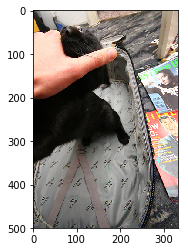

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

# 载入 coco 相关 api
import sys
sys.path.append(r'D:\API\cocoapi\PythonAPI')
from pycocotools.dataset import Loader
%matplotlib inline

dataType = 'val2017'
root = 'E:/Data/coco'
catNms = ['cat', 'dog', 'person']  # 选择包含 'cat', 'dog', 'person' 的图片
annType = 'annotations_trainval2017'

loader = Loader(dataType, catNms, root, annType)

print(f'总共包含图片 {len(loader)} 张')

for i, ann in enumerate(loader.images):
    w, h = ann['height'], ann['width']
    print(f'第 {i+1} 张图片的高和宽分别为: {w, h}')

img, labels = loader[1]
plt.imshow(img);

In [2]:
img.shape

(500, 333, 3)

In [3]:
img.transpose((2, 0, 1)).shape

(3, 500, 333)

In [4]:
cd ../app/

D:\API\CV\app


In [5]:
from detection.bbox import MultiBox
from detection.anchor import RPNAnchorGenerator

In [6]:
def getX(img):
    # 将 img (h, w, 3) 转换为 (1, 3, h, w)
    img = img.transpose((2, 0, 1))
    return np.expand_dims(img, 0)

In [7]:
img, label = loader[0]
img = cv2.resize(img, (800, 800))
X = getX(img)
img.shape, X.shape

((800, 800, 3), (1, 3, 800, 800))

In [8]:
from gluoncv.model_zoo import vgg16
from mxnet import nd
net = vgg16(pretrained=True)

imgs = nd.array(X)
x = imgs
for layer in net.features[:29]:
    x = layer(x)
    if "conv" in layer.name:
        print(layer.name, x.shape)

features = net.features[:29]
xs = features(imgs)
xs.shape

vgg0_conv0 (1, 64, 800, 800)
vgg0_conv1 (1, 64, 800, 800)
vgg0_conv2 (1, 128, 400, 400)
vgg0_conv3 (1, 128, 400, 400)
vgg0_conv4 (1, 256, 200, 200)
vgg0_conv5 (1, 256, 200, 200)
vgg0_conv6 (1, 256, 200, 200)
vgg0_conv7 (1, 512, 100, 100)
vgg0_conv8 (1, 512, 100, 100)
vgg0_conv9 (1, 512, 100, 100)
vgg0_conv10 (1, 512, 50, 50)
vgg0_conv11 (1, 512, 50, 50)
vgg0_conv12 (1, 512, 50, 50)


(1, 512, 50, 50)

In [9]:
from mxnet import init, gluon, autograd
from mxnet.gluon import nn


class RPNProposal(nn.HybridBlock):
    def __init__(self, channels, stride, base_size, ratios, scales, alloc_size, **kwargs):
        super().__init__(**kwargs)
        weight_initializer = init.Normal(0.01)

        with self.name_scope():
            self.anchor_generator = RPNAnchorGenerator(
                stride, base_size, ratios, scales, alloc_size)
            anchor_depth = self.anchor_generator.num_depth
            self.conv1 = nn.HybridSequential()
            self.conv1.add(nn.Conv2D(channels, 3, 1, 1,
                                     weight_initializer=weight_initializer))
            self.conv1.add(nn.Activation('relu'))
            # use sigmoid instead of softmax, reduce channel numbers
            self.score = nn.Conv2D(anchor_depth, 1, 1, 0,
                                   weight_initializer=weight_initializer)
            self.loc = nn.Conv2D(anchor_depth * 4, 1, 1, 0,
                                 weight_initializer=weight_initializer)


channels = 256
base_size = 2**4  # 特征图的每个像素的感受野大小
scales = [8, 16, 32]  # 锚框相对于 reference box 的尺度
ratios = [0.5, 1, 2]  # reference box 与锚框的高宽的比率（aspect ratios）
stride = base_size  # 在原图上滑动的步长
alloc_size = (128, 128)  # 一个比较大的特征图的锚框生成模板
alloc_size = (128, 128)  # 一个比较大的特征图的锚框生成模板
self = RPNProposal(channels, stride, base_size, ratios, scales, alloc_size)
self.initialize()

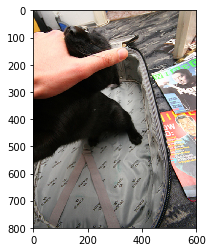

In [10]:
imgs = []
labels = []
for img, label in loader:
    img = cv2.resize(img, (600, 800))  # resize 为 (600，800)
    plt.imshow(img);
    imgs.append(getX(img))
    labels.append(label)
imgs = nd.array(np.concatenate(imgs)) # 一个批量的图片
labels = nd.array(np.stack(labels))  # 一个批量的标注信息

In [11]:
imgs.shape

(2, 3, 800, 600)

In [17]:
from gluoncv.nn.coder import NormalizedBoxCenterDecoder
from gluoncv.nn.bbox import BBoxCornerToCenter, BBoxClipToImage
stds = (0.1, 0.1, 0.2, 0.2)
means = (0., 0., 0., 0.)

fs = features(imgs)        # 获取特征图张量
F = nd
A = self.anchor_generator(fs)    # (xmin,ymin,xmax,ymax) 形式的锚框
box_to_center = BBoxCornerToCenter()  
B = box_to_center(A)      # (x,y,w,h) 形式的锚框
x = self.conv1(fs)    # conv1 卷积
raw_rpn_scores = self.score(x).transpose(axes=(0, 2, 3, 1)).reshape((0, -1,1))  # 激活之前的 score
rpn_scores = F.sigmoid(F.stop_gradient(raw_rpn_scores))    # 激活后的 score
rpn_box_pred = self.loc(x).transpose(axes=(0, 2, 3, 1)).reshape((0, -1, 4))  # loc 预测偏移量 (tx,ty,tw,yh)
box_decoder = NormalizedBoxCenterDecoder(stds, means)
roi = box_decoder(rpn_box_pred, B)  # 解码后的 G
print(roi.shape)
clipper = BBoxClipToImage()
roi = clipper(roi, imgs)  # 裁剪超出边界的边界

(2, 16650, 4)


In [46]:
min_size = 5  # 最小锚框的尺寸
xmin, ymin, xmax, ymax = roi.split(axis=-1, num_outputs=4) # 拆分坐标
width = xmax - xmin  # 锚框宽度的集合
height = ymax - ymin  # # 锚框高度的集合
invalid = (width < min_size) + (height < min_size) # 所有小于 min_size 的高宽
score = F.where(invalid, F.ones_like(invalid) * -1, rpn_scores)
invalid = F.repeat(invalid, axis=-1, repeats=4)
roi = F.where(invalid, F.ones_like(invalid) * -1, roi)

In [47]:
roi


[[[ -1.        -1.        -1.        -1.      ]
  [375.71704   10.553279 417.0299    36.06915 ]
  [  0.       500.23947  600.       800.      ]
  ...
  [553.39777  620.2787   600.       800.      ]
  [252.61125  477.94223  600.       624.02765 ]
  [548.5342    79.723206 600.       800.      ]]

 [[  0.         0.        24.502598  31.323145]
  [ 90.087265   0.       227.28883   36.439598]
  [  0.       163.5744   600.       656.3437  ]
  ...
  [530.62     637.4205   600.       800.      ]
  [475.9631   666.4762   600.       800.      ]
  [394.92236  400.29358  600.       800.      ]]]
<NDArray 2x16650x4 @cpu(0)>

In [45]:
invalid


[[[1. 1. 1. 1.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]
<NDArray 2x16650x4 @cpu(0)>